In [1]:
# imports
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdDepictor
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import rdkit.Geometry as rdGeometry
from rdkit.Chem.Draw import IPythonConsole
from matplotlib.colors import ColorConverter
from IPython.core.display import display
from IPython.core.display import SVG
import numpy as np
import math
from copy import deepcopy

# Structure representation

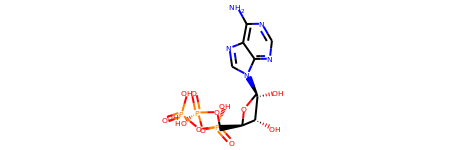

In [2]:
# 3D
lig = Chem.MolFromMol2File('../examples/ligand.mol2')
lig

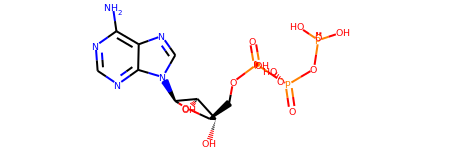

In [3]:
# canonical from 3D
lig1 = deepcopy(lig)
rdMolTransforms.CanonicalizeMol(lig1)
lig1

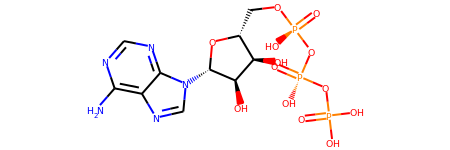

In [4]:
# 3D match (same as canonical from canonical 3D...)
lig2 = deepcopy(lig)
rdDepictor.GenerateDepictionMatching3DStructure(lig2, lig)
lig2

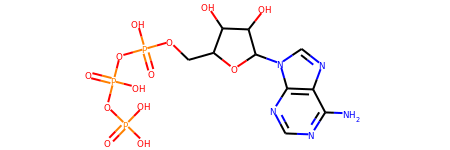

In [5]:
# 2D
smiles = Chem.MolToSmiles(lig)
lig3 = Chem.MolFromSmiles(smiles)
lig3

# Transform structures

In [6]:
# rotate around the origin
def rotate(mol, deg=0):
    rotated = deepcopy(mol)
    rad = math.pi*deg/180
    conf = rotated.GetConformer()
    for i in range(conf.GetNumAtoms()):
        point = conf.GetAtomPosition(i)
        newx = point.x * math.cos(rad) + point.y * math.sin(rad)
        newy = -point.x * math.sin(rad) + point.y * math.cos(rad)
        conf.SetAtomPosition(i, [newx, newy, point.z])
    rotated.AddConformer(conf)
    return rotated

In [7]:
# flip around an axis
def flip(mol, axis='x'):
    flipped = deepcopy(mol)
    conf = flipped.GetConformer()
    if axis == 'x':
        for i in range(conf.GetNumAtoms()):
            point = conf.GetAtomPosition(i)
            conf.SetAtomPosition(i, [point.x, -point.y, point.z])
    elif axis == 'y':
        for i in range(conf.GetNumAtoms()):
            point = conf.GetAtomPosition(i)
            conf.SetAtomPosition(i, [-point.x, point.y, point.z])
    flipped.AddConformer(conf)
    return flipped

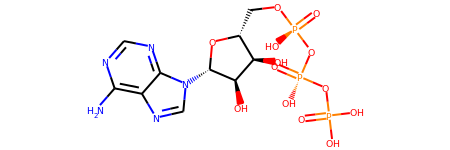

In [8]:
lig2

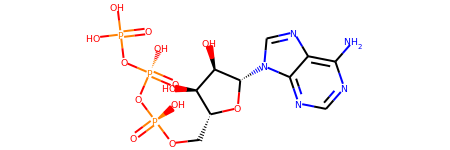

In [9]:
rotate(lig2,180)

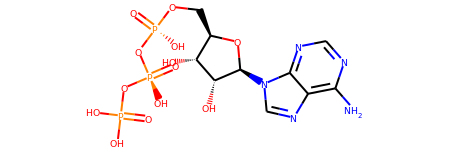

In [10]:
flip(lig2,'y')

# Annotate drawings

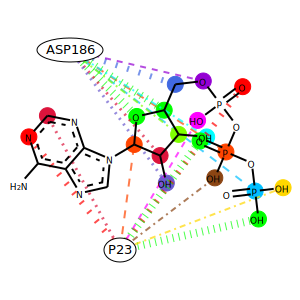

In [41]:
interactions = {
    'HBdonor': {
        'color': 'orangered',
        'dash': '8,8',
        'width': '2',
    },
    'HBacceptor': {
        'color': 'deepskyblue',
        'dash' : '8,8',
        'width': '2',
    },
    'cation': {
        'color': 'red',
        'dash': '2,10',
        'width': '6',
    },
    'anion': {
        'color': 'royalblue',
        'dash': '2,10',
        'width': '6',
    },
    'XBdonor': {
        'color': 'magenta',
        'dash': '6,6',
        'width': '2',
    },
    'XBacceptor': {
        'color': 'darkviolet',
        'dash': '6,6',
        'width': '2',
    },
    'hydrophobic': {
        'color': 'lime',
        'dash': '1,5',
        'width': '8',
    },
    'FaceToFace':{
        'color': 'saddlebrown',
        'dash': '6,4,2,4',
        'width': '2',
    },
    'EdgeToFace':{
        'color': 'chartreuse',
        'dash': '6,4,2,4',
        'width': '2',
    },
    'pi-cation':{
        'color': 'gold',
        'dash': '6,4,2,4',
        'width': '2',
    },
    'cation-pi':{
        'color': 'cyan',
        'dash': '6,4,2,4',
        'width': '2',
    },
    'MBdonor':{
        'color': 'crimson',
        'dash': '2,5',
        'width': '3',
    },
    'MBacceptor':{
        'color': 'slateblue',
        'dash': '2,5',
        'width': '3',
    },
}
residues = {
    'ASP186': {
        'HBdonor':[1],
        'HBacceptor':[2],
        'cation':[],
        'anion':[3],
        'XBdonor':[],
        'XBacceptor': [4],
        'hydrophobic':[5,6],
        'FaceToFace':[],
        'EdgeToFace':[7],
        'pi-cation':[],
        'cation-pi':[8],
        'MBdonor':[9],
        'MBacceptor':[10],
        'x':70, 'y':50},
    'P23': {
        'HBdonor':[11],
        'HBacceptor':[],
        'cation':[12,17],
        'anion':[],
        'XBdonor':[13],
        'XBacceptor': [],
        'hydrophobic':[18,19],
        'FaceToFace':[14],
        'EdgeToFace':[],
        'pi-cation':[15],
        'cation-pi':[],
        'MBdonor':[16],
        'MBacceptor':[],
        'x':120, 'y':250},
}

# Create canvas with options
drawer = Draw.MolDraw2DSVG(300,300)
palette = ColorConverter()
options = drawer.drawOptions()
options.useBWAtomPalette()
options.padding = 0
options.additionalAtomLabelPadding = 0.1
drawer.DrawMolecule(lig2)
drawer.FinishDrawing()
img = drawer.GetDrawingText().replace('svg:','').replace('</svg>','')
img = img.split('\n')
header = img[:8]
mol = img[8:]

for residue in residues:
    svg = []
    x = residues[residue]['x']
    y = residues[residue]['y']
    for i in interactions:
        color = interactions[i]['color']
        # add interactions with residues
        atoms = residues[residue][i]
        if atoms:
            for atom in atoms:
                # coordinates of the atom on the canvas
                at = drawer.GetDrawCoords(atom)
                # draw dashed line between interacting atom and residue
                svg += ['''<ellipse cx='{ax}' cy='{ay}' rx='8' ry='8' style='fill:{c};fill-rule:evenodd;stroke:{c};stroke-width:1px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<path d='M {px},{py} {ax},{ay}' stroke-dasharray='{dash}' style='fill:none;fill-rule:evenodd;stroke:{c};stroke-width:{w}px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:0.7' />'''.format(
                    c=palette.colors[color], dash=interactions[i]['dash'], w=interactions[i]['width'],
                    px=x, py=y, ax=at.x, ay=at.y)] # insert the line before the drawing of the molecule
    # draw the residue
    svg += ['''<ellipse cx='{cx}' cy='{cy}' rx='{rx}' ry='12' style='fill:white;fill-rule:evenodd;stroke:black;stroke-width:1px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1' />
<text x='{tx}' y='{ty}' style='font-size:13px;font-style:normal;font-weight:normal;fill-opacity:1;stroke:none;font-family:sans-serif;text-anchor:start;fill:#000000' ><tspan>{text}</tspan></text>'''.format(
        text=residue, tx=x-4*len(residue), ty=y+4,
        cx=x, cy=y, rx=int(len(residue)*5.8)-1)]
    header += svg
    
img = '\n'.join(header + mol)
img += '</svg>'
SVG(img)